# ADMM applied in Neural Networks with Mnist dataset


In [1]:
# Preparation with environment for notebook
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from NeuralNetwork.data_utils import *

# Allow inline matplotlib figures appear in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Allow auto-reload of external modules 
%load_ext autoreload
%autoreload 2

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Preprocessing and Loading of dataset

In [2]:
# Load Mnist Data
mnistDir = "NeuralNetwork/MnistData"
X_train,Y_train,X_test,Y_test = getMnistData(mnistDir)

# Check the size of the training and test data.
print 'Training data shape: ', X_train.shape
print 'Training labels shape: ', Y_train.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', Y_test.shape

Training data shape:  (60000, 28, 28)
Training labels shape:  (60000,)
Test data shape:  (10000, 28, 28)
Test labels shape:  (10000,)


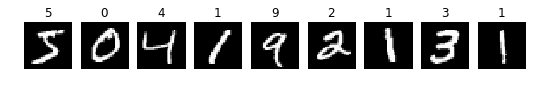

In [3]:
# Display part of the Mnist data
for xi in range(0,9):
    plt.subplot(1,10,xi+1)
    plt.imshow(X_train[xi])
    plt.axis('off')
    plt.title(Y_train[xi])

## Test NeuralNetwork


hasLambda =  False
Xtr:  (784, 20) Xte:  (784, 20) Ytr:  (20,) Yte:  (20,)
[]   [[]]   [[], []]
Initializing a neural network with :  1  hidden layers, hidden layer dimension: [300]
Total training time: 0.371953s
Prediction accuracy: 1.000000


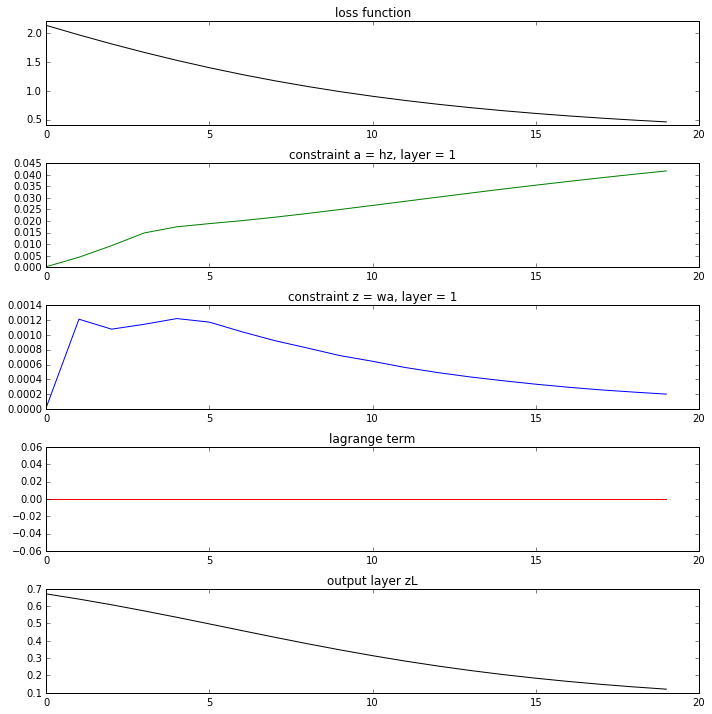

In [60]:
# Get MiniPatch
def getMiniPatch(X_train, Y_train, X_test, Y_test, trNum, teNum, transposed):
    # Subsample the data for more efficient code execution 
    trainNum = trNum
    mask = range(trainNum)
    #mask = range(30000, 30000 +trainNum)
    Xtr = X_train[mask]
    Ytr = Y_train[mask]
    
    testNum = teNum
    mask = range(testNum)
    #mask = range(5000,5000+testNum)
    Xte = X_test[mask]
    Yte = Y_test[mask]
    
    # Reshape the image data into rows
    Xtr = np.reshape(Xtr, (Xtr.shape[0], -1))
    Xte = np.reshape(Xte, (Xte.shape[0], -1))
   
    # print Xtr.shape, Xte.shape
    if not transposed:
        return Xtr, Xtr, Ytr, Yte
    else:
        return Xtr.T, Xte.T, Ytr, Yte

def preprocess(X):
    
#     # return X
#     X = X.astype(np.float64)
#     # Mean subtraction
#     X -= np.mean(X)  
    
#     # Normalization
#     X /= np.std(X, axis = 0)
    
    return X
    
    
from NeuralNetwork.neural_network import *
import time


case = [(20,20)]#,(5000,50)]#,(500,10),(5000,10),(5000,500),(20000,500),(20000, 2000)]
lam = [False]
i = 0
for la in lam:
    print 'hasLambda = ',la
    for (trNum,teNum) in case:
        X_tr, X_te, Y_tr, Y_te = getMiniPatch(preprocess(X_train), Y_train, X_train, Y_train, trNum, teNum, 1)
        print 'Xtr: ', X_tr.shape, 'Xte: ', X_te.shape, 'Ytr: ', Y_tr.shape, 'Yte: ', Y_te.shape
        
        # Initialize network
        hiddenLayer = [300]
        classNum = 10 
        epsilon = 0.001 # 
        #epsilon=np.sqrt(0.1/trNum)
        network = NeuralNetwork(X_tr, Y_tr, classNum, hiddenLayer, epsilon)
        # Train
        weightConsWeight = 1
        activConsWeight = 10
        iterNum = 20
        hasLambda = la
        tic = time.time()
        calLoss = True
        
        """ 
        Input:
        weightConsWeight, activConsWeight
        iterNum:    iteration to perform Admm updates
        hasLambda:  whether include Lambda update
        lossType:   one of {'hinge', 'msq', 'smx'}, default is 'smx'
        minMethod:  if lossType is 'smx', the method to minimize the zLastUpdate has to be specified (for it's not in closed form), 
                    it can be one of {'prox','gd','newton'}, default is 'prox';
        tau, ite:   if lossType is 'smx', the step size and iteration of gradient descent/proximal gradient have to be specified, 
                    default: tau=0.01, ite=25; 
        """
        #network.train(weightConsWeight, activConsWeight, iterNum, hasLambda,lossType = 'hinge')
        network.train(weightConsWeight, activConsWeight, iterNum, hasLambda, calLoss, lossType = 'smx',
                      minMethod = 'prox', tau=0.001, ite= 15)
        toc = time.time()
        print 'Total training time: %fs' % (toc - tic)

        # Predict
        Ypred = network.predict(X_te)
        print 'Prediction accuracy: %f' %np.mean(Ypred == Y_te)
        
        L = len(hiddenLayer)
        if calLoss:
            fig = plt.figure()
            gs = gridspec.GridSpec(5,L)
            dataLoss = fig.add_subplot(gs[0,:])
            dataLoss.set_title('loss function')
            dataLoss.plot(network.dataLoss, 'k-')

            for l in range(0,L):
                aloss = fig.add_subplot(gs[1,l])
                aloss.set_title('constraint a = hz, layer = %d' % (l+1))
                aloss.plot(network.aConstrLoss[l], 'g-')
                
                zloss = fig.add_subplot(gs[2,l])
                zloss.set_title('constraint z = wa, layer = %d' % (l+1))
                zloss.plot(network.zConstrLoss[l], 'b-')
                
            lag = fig.add_subplot(gs[3,:])
            lag.set_title('lagrange term')
            lag.plot(network.lagraLoss, 'r-')
            
            zLLoss = fig.add_subplot(gs[4,:])
            zLLoss.set_title('output layer zL')
            zLLoss.plot(network.zConstrLoss[L], 'k-')
            
            plt.tight_layout()
            plt.show()
        
